In [1]:
from math import sin, cos, tan, pi
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('imu_data.csv')
len(data)

2000

In [14]:
#initialization angles
ax = data.Ax[0]/16384
ay = data.Ay[0]/16384
az = data.Az[0]/16384
ax_i = math.atan2(ax, math.sqrt(ax ** 2.0 + az ** 2.0))
ay_i = math.atan2(ay, math.sqrt(ay ** 2.0 + az ** 2.0))
az_i = math.atan2(az, math.sqrt(ay ** 2.0 + ax ** 2.0))

In [15]:
data.head()

,t,Ax,Ay,Az,Gx,Gy,Gz
0,0.000000,0.098145,0.026367,0.816162,-0.679389,1.076336,-1.152672
1,0.000197,0.101562,0.030762,0.815186,-3.007634,1.854962,0.114504
2,0.019354,0.106201,0.028809,0.838867,-6.396947,2.618321,0.572519
3,0.037792,0.104004,0.042969,0.843750,-12.022901,3.877863,1.351145
4,0.056218,0.079590,0.013672,0.841797,-6.931298,3.267176,-0.099237


In [16]:
T = data.t[0:1000]

In [26]:
#Number of Iterations
timesteps = 1000

#Gyroscope Bias
biasx = 0.0
biasy = 0.0
biasz = 0.0

#For angles initialization
phi_hat = [ax_i]
theta_hat = [ay_i]
shi_hat = [az_i]

gtx = [ax_i]
gty = [ay_i]
gtz = [az_i]

atx = [ax_i]
aty = [ay_i]
atz = [az_i]

In [27]:
C = np.array([[1, 0, 0, 0, 0, 0], 
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0]])
P = np.eye(6)*0.1
Q = np.eye(6)*2
R = np.eye(3)*3
X = np.array([[ax_i], [0], [ay_i], [0], [az_i], [0]]) #initial State

In [28]:
for i in range(1,timesteps):
    dt = (data.t[i] - data.t[i-1])
    # Raw accelerometer data to meaningful Data 
    ax = data.Ax[i]/16384
    ay = data.Ay[i]/16384
    az = data.Az[i]/16384
    atx.append(math.atan2(ax, math.sqrt(ax ** 2.0 + az ** 2.0)))
    aty.append(math.atan2(ay, math.sqrt(ay ** 2.0 + az ** 2.0)))
    atz.append(math.atan2(az, math.sqrt(ay ** 2.0 + ax ** 2.0)))
        
    # Raw gyro data to meaningful Data 
    x = data.Gx[i] * math.pi*(data.t[i]-data.t[i-1])/ (180.0*131)
    y = data.Gy[i] * math.pi*(data.t[i]-data.t[i-1]) / (180.0*131)
    z = data.Gz[i] * math.pi*(data.t[i]-data.t[i-1]) / (180.0*131)
    x -= biasx
    y -= biasy
    z -= biasz
    
    # Calculate Euler angle derivatives 
    phi_dot = x + sin(phi_hat[i-1]) * tan(theta_hat[i-1]) * y + cos(phi_hat[i-1]) * tan(theta_hat[i-1]) * z
    theta_dot = cos(phi_hat[i-1]) * y - sin(phi_hat[i-1]) * z
    shi_dot = y*(sin(phi_hat[i-1])/cos(theta_hat[i-1])) + z*(cos(phi_hat[i-1])/cos(theta_hat[i-1]))
    
    #Store values from only gyroscope
    gtx.append(phi_hat[i-1] + (dt) * phi_dot)
    gty.append(theta_hat[i-1] + (dt) * phi_dot)
    gtz.append(shi_hat[i-1] + (dt) * phi_dot)
    
    
    
    # Kalman filter
    A = np.array([[1, -dt, 0, 0, 0, 0], 
                  [0, 1  , 0, 0, 0, 0], 
                  [0, 0, 1, -dt, 0, 0], 
                  [0, 0, 0, 1, 0, 0  ],
                  [0, 0, 0, 0, 1, -dt], 
                  [0, 0, 0, 0, 0  , 1],
                 ])
    B = np.array([[dt, 0, 0], 
                  [0, 0, 0],
                  [0, dt,0],
                  [0, 0, 0],
                  [0, 0,dt],
                  [0, 0, 0]])

    U = np.array([[phi_dot], 
                  [theta_dot],
                  [shi_dot]])
    
    X = A.dot(X) + B.dot(U)
    
    P = A.dot(P.dot(np.transpose(A))) + Q

    Z = np.array([[atx[i]],
                  [aty[i]],
                  [atz[i]]])
    
    Y = Z - C.dot(X)
    S = R + C.dot(P.dot(np.transpose(C)))
    K = P.dot(np.transpose(C).dot(np.linalg.inv(S)))
    X = X + K.dot(Y)
    P = (np.eye(6) - K.dot(C)).dot(P)

    phi_hat.append(X[0])
    theta_hat.append(X[2])
    shi_hat.append(X[4])

Text(0.5, 1.0, 'X-orientation')

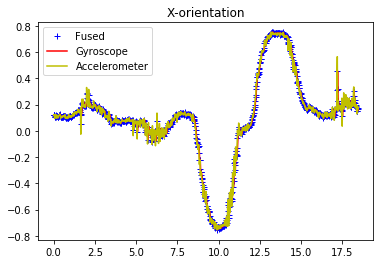

In [29]:
fig, ax = plt.subplots()
ax.plot(T,phi_hat, '+b', label='Fused')
ax.plot(T,gtx, 'r', label='Gyroscope')
ax.plot(T,atx, 'y', label='Accelerometer')
leg = ax.legend();
plt.title('X-orientation')

Text(0.5, 1.0, 'Y-orientation')

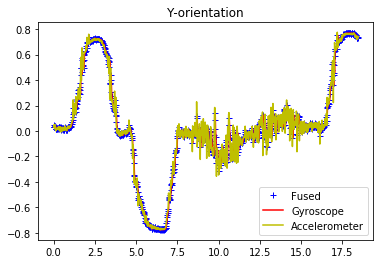

In [30]:
fig, ax = plt.subplots()
ax.plot(T,theta_hat, '+b', label='Fused')
ax.plot(T,gty, 'r', label='Gyroscope')
ax.plot(T,aty, 'y', label='Accelerometer')
leg = ax.legend();
plt.title('Y-orientation')

Text(0.5, 1.0, 'Z-orientation')

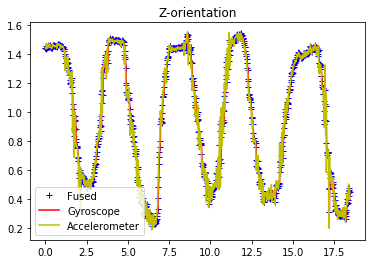

In [31]:
fig, ax = plt.subplots()
ax.plot(T,shi_hat, '+b', label='Fused')
ax.plot(T,gtz, 'r', label='Gyroscope')
ax.plot(T,atz, 'y', label='Accelerometer')
leg = ax.legend();
plt.title('Z-orientation')